In [ ]:
#import sttaements

import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import math


# Loading Dataset

In [ ]:
mask_path='/input/kittiroadsegmentation/training/gt_image_2'
img_path='/input/kittiroadsegmentation/training/image_2'

test_path='/input/kittiroadsegmentation/testing' # testing is on videos

In [ ]:
# Number of training examples
train_set_size = int(len(os.listdir(img_path)) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(os.listdir(img_path)) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = int(len(os.listdir(img_path)) - train_set_size - validation_set_size)
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [ ]:
def loadImages(path,mask=False):
    result = [] 
    images = os.listdir(path)
    if mask==True:
        images = [entry for entry in images if "road" in entry]

    images=sorted(images)
    
    print(images)
    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_im = im.resize((128, 128))
        res = np.asarray(resized_im)
        result.append(res)
    return np.array(result)

In [ ]:
%matplotlib inline
def show_images(images, num_images_to_show):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = images[i-1,:]
        plt.imshow(img)


In [ ]:
data=loadImages(img_path,mask=False)

['um_000000.png', 'um_000001.png', 'um_000002.png', 'um_000003.png', 'um_000004.png', 'um_000005.png', 'um_000006.png', 'um_000007.png', 'um_000008.png', 'um_000009.png', 'um_000010.png', 'um_000011.png', 'um_000012.png', 'um_000013.png', 'um_000014.png', 'um_000015.png', 'um_000016.png', 'um_000017.png', 'um_000018.png', 'um_000019.png', 'um_000020.png', 'um_000021.png', 'um_000022.png', 'um_000023.png', 'um_000024.png', 'um_000025.png', 'um_000026.png', 'um_000027.png', 'um_000028.png', 'um_000029.png', 'um_000030.png', 'um_000031.png', 'um_000032.png', 'um_000033.png', 'um_000034.png', 'um_000035.png', 'um_000036.png', 'um_000037.png', 'um_000038.png', 'um_000039.png', 'um_000040.png', 'um_000041.png', 'um_000042.png', 'um_000043.png', 'um_000044.png', 'um_000045.png', 'um_000046.png', 'um_000047.png', 'um_000048.png', 'um_000049.png', 'um_000050.png', 'um_000051.png', 'um_000052.png', 'um_000053.png', 'um_000054.png', 'um_000055.png', 'um_000056.png', 'um_000057.png', 'um_000058.pn

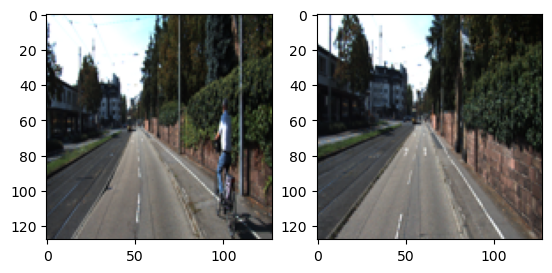

In [ ]:
show_images(data,2)

In [ ]:
true_mask=loadImages(mask_path,mask=True)

['um_road_000000.png', 'um_road_000001.png', 'um_road_000002.png', 'um_road_000003.png', 'um_road_000004.png', 'um_road_000005.png', 'um_road_000006.png', 'um_road_000007.png', 'um_road_000008.png', 'um_road_000009.png', 'um_road_000010.png', 'um_road_000011.png', 'um_road_000012.png', 'um_road_000013.png', 'um_road_000014.png', 'um_road_000015.png', 'um_road_000016.png', 'um_road_000017.png', 'um_road_000018.png', 'um_road_000019.png', 'um_road_000020.png', 'um_road_000021.png', 'um_road_000022.png', 'um_road_000023.png', 'um_road_000024.png', 'um_road_000025.png', 'um_road_000026.png', 'um_road_000027.png', 'um_road_000028.png', 'um_road_000029.png', 'um_road_000030.png', 'um_road_000031.png', 'um_road_000032.png', 'um_road_000033.png', 'um_road_000034.png', 'um_road_000035.png', 'um_road_000036.png', 'um_road_000037.png', 'um_road_000038.png', 'um_road_000039.png', 'um_road_000040.png', 'um_road_000041.png', 'um_road_000042.png', 'um_road_000043.png', 'um_road_000044.png', 'um_road_

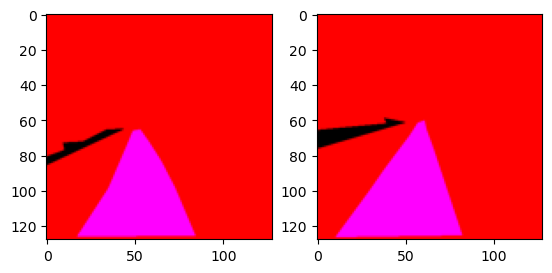

In [ ]:
show_images(true_mask,2)

In [ ]:
def convert_to_binary_mask(true_mask):
    noMasks=len(true_mask)
    for i in range(noMasks):
        #convert all masks to just binary masks (road and no road)
        road_label =np.array([255, 0, 255])
        cond=np.all(true_mask[i] == road_label, axis = 2)
        true_mask[i]=true_mask[i] * cond[..., np.newaxis]

In [ ]:
convert_to_binary_mask(true_mask)

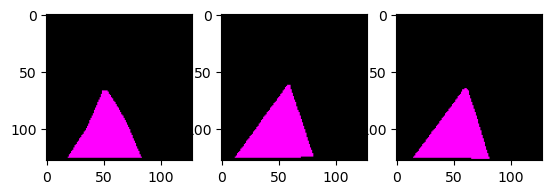

In [ ]:
show_images(true_mask,3)

In [ ]:
true_mask=np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask=np.expand_dims(true_mask, axis=-1)

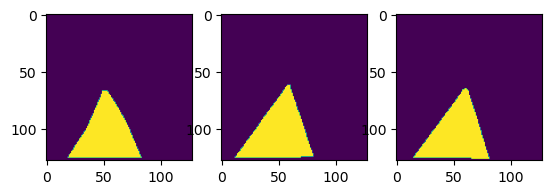

In [ ]:
show_images(true_mask,3)

In [ ]:
true_mask[true_mask != 0.0]=1.0

In [ ]:
data  = data / 255.0

Albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5,border_mode=cv2.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])


In [ ]:
data.shape

(289, 128, 128, 3)

In [ ]:
true_mask.shape

(289, 128, 128, 1)

In [ ]:
data=data.astype(np.float32)
true_mask=true_mask.astype(np.float32)

In [ ]:
test_aug=augmentation_pipeline(image=data[5], mask=true_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

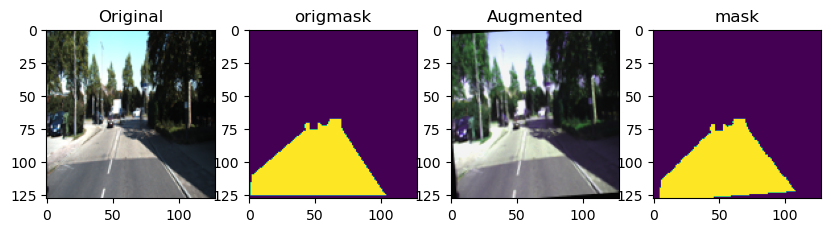

In [ ]:
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(true_mask[5])
ax[1].set_title("origmask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()


In [ ]:
NewIMGS=10
for i in range(len(data)):
    for j in range(NewIMGS):
        image = data[i]
        mask = true_mask[i]
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        image_augmented = augmented["image"]
        mask_augmented = augmented["mask"]
        data = np.vstack((data, image_augmented[np.newaxis,...]))
        true_mask = np.vstack((true_mask, mask_augmented[np.newaxis,...]))

In [ ]:
data.shape

(3179, 128, 128, 3)

In [ ]:
true_mask.shape

(3179, 128, 128, 1)

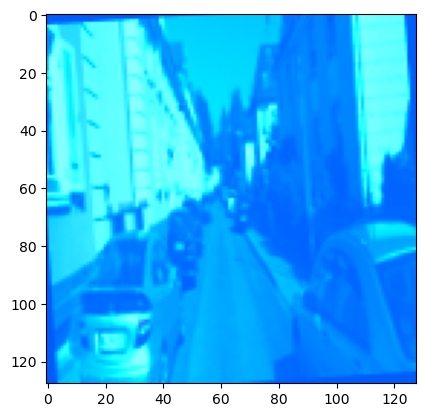

In [ ]:
show_images(data[-200:],1)

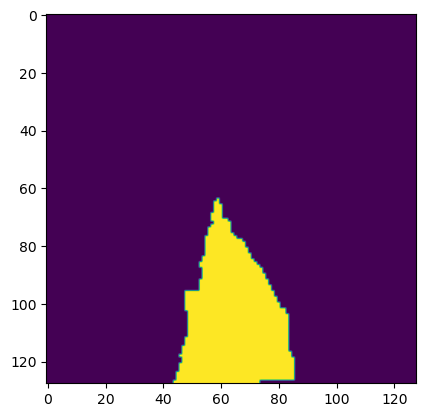

In [ ]:
show_images(true_mask[-200:],1)

In [ ]:
# Number of training examples
train_set_size = int(len(data) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(data) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = len(data) - train_set_size - validation_set_size
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 2543
Number of Validation Examples: 317
Number of Testing Examples: 319


In [ ]:
X_test=data[:test_set_size].transpose((0, 3, 1, 2))
y_test=true_mask[:test_set_size].transpose((0, 3, 1, 2))
print(f'test set size {X_test.shape}')


#rest of the data will be agumented and shuffled for training
data=data[test_set_size:]
true_mask=true_mask[test_set_size:]

# Shuffle the indices
shuffled_indices = np.random.permutation(len(data))

# Use the shuffled indices to shuffle both arrays
shuffled_data = data[shuffled_indices]
shuffled_masks = true_mask[shuffled_indices]


test set size (319, 3, 128, 128)


In [ ]:
#train_test_validation split
X_train=shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
y_train=shuffled_masks[:train_set_size].transpose((0, 3, 1, 2))
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
print(f'val set size {X_val.shape}')

training set size (2543, 3, 128, 128)
val set size (317, 3, 128, 128)


In [ ]:
#create dataset class
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs=imgs
        self.mask=mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.imgs[idx]
    
    def get_batch_masks(self, idx):
    # Fetch a batch of inputs
        return self.mask[idx]

    
    def __getitem__(self, index):
        imgs=self.get_batch_imgs(index)
        masks=self.get_batch_masks(index)
        return imgs,masks

In [ ]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# Create a DataLoader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model U-NET

# U-NET architecture (from scratch)
# ![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
#since there is alot of double Conv in this architecture it's better to create a class to write less redundant code
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() # essentail to use nn.Module
        #ex : for the first layer
        #in_channels would be 3 for RGB image 
        #out_channels would be 64
        #bias is set to false because we apply batch norm later so it's unnecassary
        self.dconv=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.dconv(x)

    
    
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #this is not deconv this just upsampling
            self.ups.append(DoubleConv(feature*2, feature))

            

        self.left_over = DoubleConv(features[-1], features[-1]*2) #this represents the last part which starts the UP phase
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #output segmentation  map

    def forward(self,x):
        skip_connections = []
        
        #starting the down phase will iterate through the downs module
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)#save this to feed it later
            x=self.pool(x)
        
        #to move from left to right we pass through the "left_over"
        
        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2): #our goal it so feed to transposed conv and add skipped connection ups has 2 steps in each so we will make it a step of 2
            
            sc=skip_connections[idx//2]
            x=self.ups[idx](x) #step 1
            
            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) #concatination step
            x = self.ups[idx+1](concat_skip) #step 2


        return torch.sigmoid(self.final_conv(x))#last step in forward            
        

In [ ]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.eps = 1e-6

    def forward(self, y_pred, y_true):
        # Flatten the input tensors
        y_pred = y_pred.view(-1)        
        y_true = y_true.view(-1)
        # Calculate the confusion matrix
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() - intersection

        # Calculate the IoU and return the complement as the loss
        iou = intersection / (union + self.eps)
        return 1 - iou


In [ ]:
import torch.optim as optim

EPOCHS=150
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = IoULoss().to(DEVICE)
# loss_fn =nn.BCELOSS().to(DEVICE)
LEARNING_RATE=1e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []

    for train_input, train_mask in tqdm(data_loader):
        train_mask = train_mask.to(device)
        train_input=train_input.to(device)
        
        outputs=model(train_input.float())
        
        
        loss = loss_fn(outputs.float(), train_mask.float())
        
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []

    with torch.no_grad():
        for val_input, val_mask in data_loader:
            
            val_mask = val_mask.to(device)
            val_input=val_input.to(device)
            outputs=model(val_input.float())
           
            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())

    return np.mean(losses)

In [ ]:
from collections import defaultdict
history = defaultdict(list)

In [ ]:
loss=math.inf
for epoch in range(EPOCHS):


    train_loss = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)

    
    val_loss = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}')
        print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

100%|██████████| 80/80 [00:34<00:00,  2.30it/s]


Epoch 1/150
----------
Train loss 0.5493056446313858
Val   loss 0.4633599281311035



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 6/150
----------
Train loss 0.25884613767266273
Val   loss 0.2552948832511902



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 11/150
----------
Train loss 0.18359819799661636
Val   loss 0.18755525946617127



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 16/150
----------
Train loss 0.14382341429591178
Val   loss 0.15828911662101747



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 21/150
----------
Train loss 0.1146771714091301
Val   loss 0.15238528847694396



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 26/150
----------
Train loss 0.09431993216276169
Val   loss 0.12029063701629639



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 31/150
----------
Train loss 0.08305063396692276
Val   loss 0.10214724540710449



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 36/150
----------
Train loss 0.06918370872735977
Val   loss 0.09721528887748718



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 41/150
----------
Train loss 0.060177625715732576
Val   loss 0.08851585388183594



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 46/150
----------
Train loss 0.0535457044839859
Val   loss 0.08330445885658264



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 51/150
----------
Train loss 0.03641146495938301
Val   loss 0.0704453468322754



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 56/150
----------
Train loss 0.03340517655014992
Val   loss 0.07925864458084106



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 61/150
----------
Train loss 0.028887955844402312
Val   loss 0.0655176281929016



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 66/150
----------
Train loss 0.026597175747156143
Val   loss 0.06557700037956238



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 71/150
----------
Train loss 0.02376706451177597
Val   loss 0.05991455912590027



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 76/150
----------
Train loss 0.02182197794318199
Val   loss 0.0618502676486969



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 81/150
----------
Train loss 0.020550694316625595
Val   loss 0.06110977530479431



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 86/150
----------
Train loss 0.020073536783456802
Val   loss 0.05705935955047607



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 91/150
----------
Train loss 0.03078606352210045
Val   loss 0.0708194375038147



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 96/150
----------
Train loss 0.017045804858207704
Val   loss 0.05542293190956116



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 101/150
----------
Train loss 0.015445529669523238
Val   loss 0.05486244559288025



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 106/150
----------
Train loss 0.01550198793411255
Val   loss 0.0548914909362793



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 111/150
----------
Train loss 0.014366679638624192
Val   loss 0.05257962346076965



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Epoch 116/150
----------
Train loss 0.014342572540044785
Val   loss 0.051859378814697266



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 121/150
----------
Train loss 0.01413724422454834
Val   loss 0.05452011227607727



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 126/150
----------
Train loss 0.014222853630781174
Val   loss 0.05472066402435303



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 131/150
----------
Train loss 0.013116933405399323
Val   loss 0.05066947340965271



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 136/150
----------
Train loss 0.04709784537553787
Val   loss 0.1090356945991516



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 141/150
----------
Train loss 0.013976126909255981
Val   loss 0.0552173376083374



100%|██████████| 80/80 [00:33<00:00,  2.41it/s]


Epoch 146/150
----------
Train loss 0.011265355348587035
Val   loss 0.05029941201210022



100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

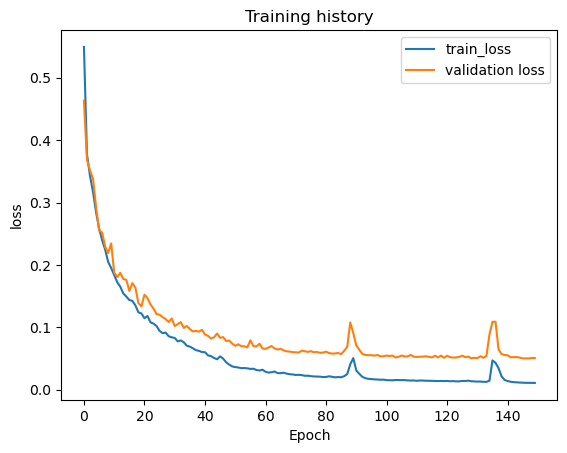

In [ ]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()


In [ ]:
prediction=model(torch.tensor(X_test[56][np.newaxis,...],device=DEVICE)).cpu().detach().numpy()

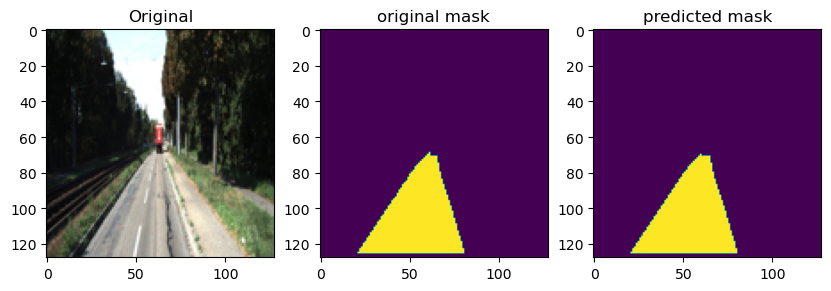

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(prediction[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


In [ ]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:
            
            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())
            
            masks.append(outputs.cpu().detach().numpy())
           
            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [ ]:
loss,masks=get_predicted_masks(model,test_dataloader,loss_fn,DEVICE)

In [ ]:
loss

0.018677520751953124

In [ ]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

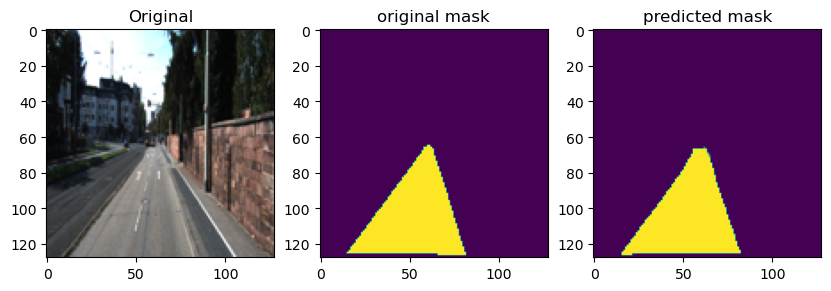

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[2].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[2].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[2].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


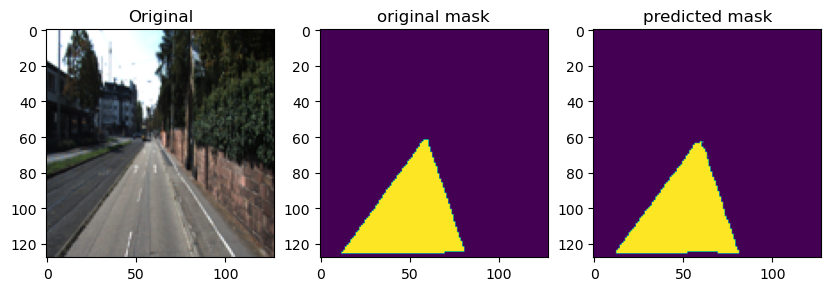

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[1].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[1].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[1].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


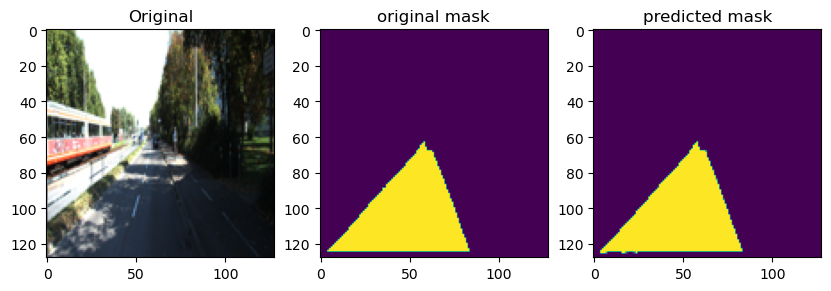

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[14].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[14].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[14].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


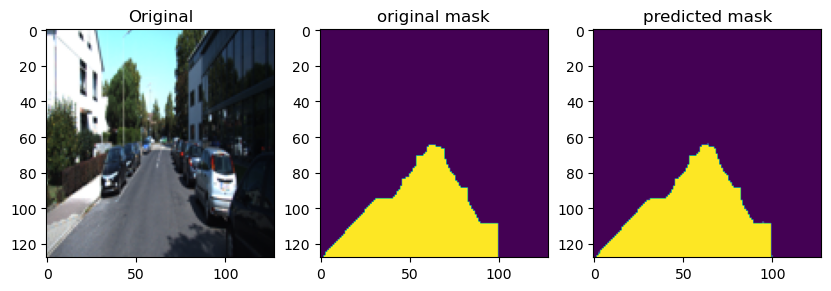

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[200].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[200].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[200].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


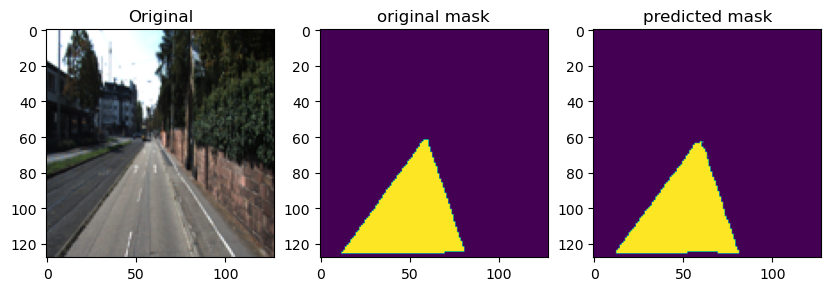

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[300].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[300].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[300].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()
